<a href="https://colab.research.google.com/github/egahqusayf/Public-Sentiment-Analysis-of-YouTube-Comments-Toward-Indonesias-Vice-Presidential-Gibran-/blob/main/notebooks/Sentiment_Analysis_Gibran_Rakabuming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup & Dependencies

In [1]:
!pip install -q torch transformers accelerate datasets sastrawi nltk scikit-learn
!pip install -U transformers accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


Import Required Libraries

In [2]:
# Core Libraries
import re
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

# Indonesian NLP
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


Load Labeled Dataset

In [3]:
df = pd.read_csv("annotated_comments_labeled.csv")

print("Jumlah data:", len(df))
df.head()


Jumlah data: 2800


,video_id,comment,likes,published_at,label
0,ZhL1ABVBqB8,Bro sori nih..\nSekedar saran aja nih.\nTolong...,0,2025-04-25T18:20:10Z,0.0
1,SzXMacu80o8,1x1 brp woii,0,2025-04-21T12:49:42Z,0.0
2,ZhL1ABVBqB8,Senantiasa Sehat Panjang Umur Mas Wapres 💙🤲,1,2025-04-25T13:57:38Z,1.0
3,SzXMacu80o8,"Katanya kan mewakili anak muda, tapi kebanyaka...",0,2025-04-21T10:41:31Z,0.0
4,kJks8qSH3ko,"Semangat pak Wapres, FAKTA tak terbantahkan kl...",7,2025-04-25T07:58:07Z,-1.0


Text Cleaning & Preprocessing

In [4]:
nltk.download("punkt")
stopwords = set(StopWordRemoverFactory().get_stop_words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_comment"] = df["comment"].astype(str).apply(clean_text)
df = df[df["clean_comment"] != ""]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Label Encoding

In [5]:
label_map = {
    -1: 0,
     0: 1,
     1: 2
}

df["label_id"] = df["label"].map(label_map)

Train–Validation Split

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_comment"],
    df["label_id"],
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)


Tokenization

In [7]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [8]:
train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

val_encodings = tokenizer(
    val_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)


Custom Dataset Class

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [10]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

Evaluation Metrics Function

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Training Configuration

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=100
)


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Model Training & Evaluation

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.979365,0.686213,0.700917,0.687878,0.700917,0.673883
2,0.725738,0.584995,0.735780,0.731020,0.735780,0.727346
3,0.518483,0.535535,0.785321,0.784848,0.785321,0.785070
4,0.446998,0.556451,0.785321,0.789113,0.785321,0.785330
5,0.428769,0.551162,0.792661,0.792167,0.792661,0.792150


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=685, training_loss=0.5925194928245823, metrics={'train_runtime': 638.6459, 'train_samples_per_second': 17.067, 'train_steps_per_second': 1.073, 'total_flos': 716984063308800.0, 'train_loss': 0.5925194928245823, 'epoch': 5.0})

In [15]:
eval_result = trainer.evaluate()

print("Evaluation Result:")
for k, v in eval_result.items():
    print(f"{k}: {v:.4f}")

Evaluation Result:
eval_loss: 0.5512
eval_accuracy: 0.7927
eval_precision: 0.7922
eval_recall: 0.7927
eval_f1: 0.7922
eval_runtime: 3.5174
eval_samples_per_second: 154.9430
eval_steps_per_second: 9.9500
epoch: 5.0000


Validation Prediction & Performance Report

In [16]:
predictions = trainer.predict(val_dataset)

logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

label_names = ["Negative", "Neutral", "Positive"]

print(classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=4
))


              precision    recall  f1-score   support

    Negative     0.8032    0.7665    0.7844       197
     Neutral     0.6688    0.6774    0.6731       155
    Positive     0.8800    0.9119    0.8957       193

    accuracy                         0.7927       545
   macro avg     0.7840    0.7853    0.7844       545
weighted avg     0.7922    0.7927    0.7922       545



Confusion Matrix Visualization

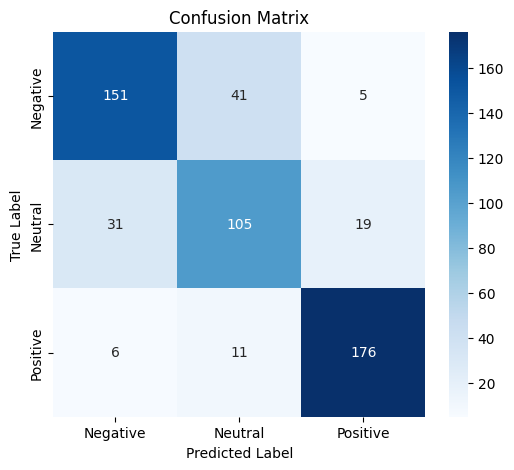

In [17]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Save Trained Model

In [18]:
SAVE_PATH = "./best_model1"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print(f"✅ Model dan tokenizer disimpan di: {SAVE_PATH}")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Model dan tokenizer disimpan di: ./best_model1


Single Text Inference Function

In [19]:
import torch
from torch.nn.functional import softmax

LABEL_MAP = {
    0: "Negatif",
    1: "Netral",
    2: "Positif"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)

    confidence, prediction = torch.max(probs, dim=1)

    return {
        "label_id": prediction.item(),
        "label": LABEL_MAP[prediction.item()],
        "confidence": confidence.item()
    }


In [20]:
sample_text = "Saya tidak memihak siapapun, tapi memang pemerintahan kali ini perlu dievaluasi besar-besaran"

result = predict_sentiment(sample_text)

print(f"Text       : {sample_text}")
print(f"Sentiment  : {result['label']}")
print(f"Confidence : {result['confidence']:.4f}")


Text       : Saya tidak memihak siapapun, tapi memang pemerintahan kali ini perlu dievaluasi besar-besaran
Sentiment  : Positif
Confidence : 0.5745


Load Unlabeled YouTube Comments

In [21]:
UNLABELED_PATH = "youtube_comments_unlabeled.csv"
df_unlabeled = pd.read_csv(UNLABELED_PATH)

print("Kolom dataset:", df_unlabeled.columns.tolist())
df_unlabeled.head()


Kolom dataset: ['video_id', 'comment', 'likes', 'published_at', 'label']


,video_id,comment,likes,published_at,label
0,ZhL1ABVBqB8,SATU KATA > KOSONG 🥱,1,2025-04-28T17:44:44Z,NaN
1,ULJErSG7F8Y,"setiap gibran bicara Hirilisasi, kiamat maju 1...",0,2025-04-30T13:18:55Z,NaN
2,SzXMacu80o8,Penyuluhan cara melakukan kebusukan ....,0,2025-04-21T11:08:29Z,NaN
3,ULJErSG7F8Y,Haduhhhhhh😂😂\nIni anak SMK / SPPN saja lebih p...,0,2025-05-15T00:41:22Z,NaN
4,SzXMacu80o8,Tolong buzzer bantu komen positif biar ngga ti...,0,2025-04-22T21:54:35Z,NaN


Preprocess & Sample Unlabeled Data

In [22]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_sample = df_unlabeled.reset_index(drop=True)

df_sample["clean_comment"] = df_sample["comment"].apply(clean_text)

texts = df_sample["clean_comment"].tolist()

print("Jumlah komentar untuk inference:", len(texts))

Jumlah komentar untuk inference: 80804


Batch Inference on Unlabeled Data

In [23]:
from tqdm import tqdm

label_map = {0: "negative", 1: "neutral", 2: "positive"}

pred_labels = []
confidences = []

model.eval()

for text in tqdm(texts, desc="Running inference"):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)

    conf, pred = torch.max(probs, dim=1)
    pred_labels.append(label_map[pred.item()])
    confidences.append(conf.item())

df_sample["predicted_sentiment"] = pred_labels
df_sample["confidence"] = confidences


Running inference: 100%|██████████| 80804/80804 [12:22<00:00, 108.83it/s]


Sentiment Distribution Visualization

In [24]:
sentiment_counts = df_sample["predicted_sentiment"].value_counts()
print(sentiment_counts)

predicted_sentiment
negative    42656
neutral     22269
positive    15879
Name: count, dtype: int64


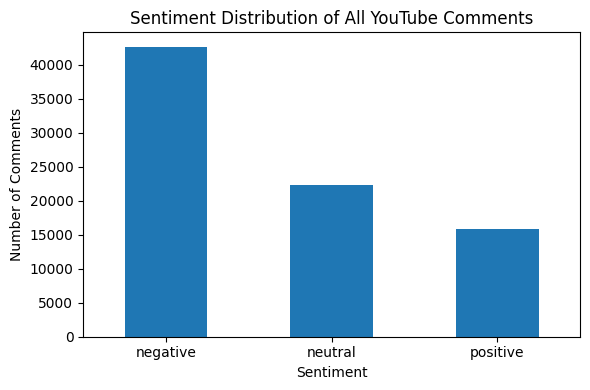

In [25]:
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind="bar")
plt.title("Sentiment Distribution of All YouTube Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

# ===== SETTING DISPLAY AGAR TEKS TIDAK TERPOTONG =====
pd.set_option("display.max_colwidth", None)

# ===== PARAMETER FILTER =====
CONF_THRESHOLD = 0.90
MIN_WORDS = 20
SENTIMENTS = ["negative", "neutral", "positive"]

# ===== TAMPILKAN KOMENTAR =====
for sent in SENTIMENTS:
    print(f"\n===== {sent.upper()} (confidence > {CONF_THRESHOLD}, ≥ {MIN_WORDS} kata) =====\n")

    filtered_df = df_sample[
        (df_sample["predicted_sentiment"] == sent) &
        (df_sample["confidence"] > CONF_THRESHOLD) &
        (df_sample["comment"].str.split().str.len() >= MIN_WORDS)
    ][["comment", "confidence"]]

    display(filtered_df.head(15))



===== NEGATIVE (confidence > 0.9, ≥ 20 kata) =====



,comment,confidence
3,"Haduhhhhhh😂😂\nIni anak SMK / SPPN saja lebih paham😂\nKalau cuma baca mas😂 percuma \nRakyat sudah tau, gaya ini sudah di pake dari 10 lalu\n\nHanya ternak 10 thn yang masih dukung dan tertipu😂😂",0.929318
48,"Mana bukti untuk janjimu membuat 19 juta lapangan kerja baru ???\n\nOmong kosong demi omong kosong keluar dari mulutmu.\n\nKamu berharap pencitraan bisa menipu kami dari kosongnya isi kepalamu ? Maaf, itu sudah tidak laku. 10 tahun sudah kami belajar dari bapakmu",0.971117
118,"Kaga ada kontribusi apa2 ikut nebeng nama, minimal malu lah. Biasanya jg mendewakan AI, situ gabisa mikir pake otak apa gimana 🤣.",0.959980
132,Masa gini aja pake buzzer si bro . Malu2 in aja lu gibran . Ketara bnr lu tanpa buzzer cmn debu . Gk guna .,0.976439
150,"Orang biasanya asal koment, maunya SIM salabim, baru aja Presiden & Wakil Presiden menjabat berapa bulan saja udah nuntut setinggi langit.",0.922309
171,"Lihat lah surendrer akhirnya pakai bot. Kalau gw malu sih.\n sekelas wapres pakai bot, kelihatan banget ngga mau di kritik lucu lucu",0.979517
262,KAYAK DI GKYPLUIT ADA YG BERNAMA MARGARET BELIAU BERFOTO DENGAN BAPAK JOKOWI KAN BUKAN BERSRTI ANAK LAKI2 DIA GA USAH IKUT WAMIL DONG,0.909662
272,"Mau uji nyali nonton ini, sampe harus bismillah berkali²\nSampe rajin berdzikir gua, astagfirull aja sampe gak kehitung\nMakasih karena bikin gua jadi berani ngedislike ini vido 😂",0.949257
302,"Mas, daripada gawe video, cepakno lapangan kerja sing mbok janjikan... Iku looo, akeh sing golek kerjooo... \n\nTak dislike yo videomu... 😂",0.961100
343,"Duku lu bialng\n""Orang yang tidak menggunakan A.I akan kalah sama orang yang menggunakan A.I""\nGiliran animator kita yang tidak menggunakan A.I ngeluarin animasi yang luarbiasa lu ngikut pansos.\nKata cobuser ""pala lu pe'a""",0.978978



===== NEUTRAL (confidence > 0.9, ≥ 20 kata) =====



,comment,confidence
100,Hilirisasi jadi andalan 😂 coba jelaskan hasil hilirisasi masuk mana? Atau masuk ke negara brp? Berdampak atau tdk utk pengembangan ekonomi indonesia? Klo ada harusnya pa prabowo tidak menghemat apbn,0.946083
164,urusin 19 juta lapangan kerja dulu \njangan ginian\nliat brapa banyak orang yang kena PHK dan susah nya mencari kerja,0.914712
169,"Coba ngaku siapa agency yang buat nih conceptnya, director nya sapa nih....😂😂😂😂 bangga banget pastinya, cair nih gede beut pasti budget nya 😂😂😂",0.910166
226,"Mohon maaf bapak saya untuk pertama kalinya berkomentar melalui platform ini karena jujur saya pribadi lebih sibuk having fun di Egypt. Tapi knp pajak yg saya bayar harus dipake untuk beli ""like"" di video anda yg sebelumnya? Mohon pencerahan",0.925866
294,"Aq langsung pause, dan langsung ke kolom komen, kok lebih seru di kolom komen yah ? Isi komen penuh dengan kata2 mutiara kepada gibran",0.924790
308,Sejauh ini 3.400 likes dari 314.000 views. Nunggu likesnya naik meroket dari Generasi muda yg merasa terwakili sama Mas ini.,0.938379
395,"pemerintah berani gak buat ambil tantangan? bukti dari generasi muda gak takut tantangan udah disebutin beberapa dalam video, tapi apa ada narasi yang menggambarkan bahwa pemerintah saat ini percaya sama generasi muda?",0.960660
493,"Kenapa kalian tidak bisa menyaring pesan yang di sampaikan? Apa karena kalian iri kepada yang menyampaikan pesan tersebut? Padahal pesan yang beliau berikan ini sangat penting bagi kehidupan kita kedepannya, kenapa kalian bisa membenci beliau padahal beliau hanya ingin melakukan yang terbaik untuk masyarakat.iq 78 minim literasi",0.938910
529,"284 juta penduduk itu data tahun 2024, either awal-pertengahan 2024 baru penduduk kita 284 juta. kalo per 2025 itu udah 285,7 juta pak, per April ini, i mean, it's already 2025 and ini dapet dari Times, WPR, etc. but anyways kan gk tau ya kapan ini video di edit",0.942997
532,"pak gibran , bisakah tiap buka rekening bank otomatis bisa mendapatkan kode QRIS pembayran. rasanya ribet sekali klo mau buka toko harus daftar QRIS. jika otomatis tiap rekening bisa dpt QR kode maka tiap orang bisa langsung berwirausaha menerima pembayaran menggunakan QRIS. nanti pajak bisa dipotongkan lewat pembayaran QRIS tsb. kode QRIS bisa langsung dicetak di kartu ATM. hanya sekedar pertanyaan.",0.939908



===== POSITIVE (confidence > 0.9, ≥ 20 kata) =====



,comment,confidence
25,INDONESIA MNGHADAPI TANTANGAN DUNIA INTERNASIONAL SAAT INI DAN KE DEPAN INSAALLAH TDAK TRTATIH2 UJIAN COBAAN SDAH TRLEWATI TNGGAL MEMOERBAIKI LBIH BAIK DAN LBIH BAIK UNTUK KITA SMUA TAK TRKECUALI..HADIR..PAK WAKIL PRESIDEN INDONESIA SELALU KJALAN YG BNAR DAN LURUS AMIN wsalam,0.982487
144,Semangat pak gibran ..manu terus utk Indonesia lebib baik..jgn sampai dikuasai oleh ormas HTI dan rombongan yg bakal lebih merusak Indonesia,0.988638
179,"teruskan mas Gibran di tunggu update selanjutnya, memang cocok nya jadi youtuber saja, jangan susah² memaksakan menjadi wapres, sebaiknya mas mundur saja tidak usah menunggu lengser, rakyat sudah tidak percaya😹",0.978913
318,"Berkat pemerintah, saya jadi dekat dengan Agama, saya bercita cita agar kelak di akhirat tidak ketemuan sampeyan dan temen teman rezim lainnya di neraka 🙏",0.925579
337,Semangat pak gibran buktiin anda layak jadi wapres mau dihina pun tetap jalan. Maklum lah mayoritas negeri kita SDM rendah hati penuh dengki,0.989910
340,"Luar biasa dedikasinya untuk bangsa ini, semangat juang yang tak kenal menyerah dan khazanah keilmuan yang tiada duanya. Ilmu kelas dunia yang diraih dari kuliah luar negeri bisa diaplikasikan dengan sangat mengagumkan. Terima kasih Eyang BJ Habibie",0.988298
420,Sangat bisa ditiru bapaknya .. karena bapak yg luar biasa anak yg biasa2 saja bisa jadi orang nomor 2 di negara demokrasi,0.951118
491,"Terimakasih tim kreatif nya, dari sini kita bisa semakin melihat bahwa pak Gibran sangat jeli dalam membaca teleprompter. Konsepnya mungkin bentuk upaya pengenalan bahwa pak Gibran sosok yang cerdas, tapi bobot bahasan yang kayak gini sangat remeh untuk dititipkan dan diminta untuk dibacakan oleh seorang wapres.\n\nPathetic...",0.979697
498,"saya mendukung niat hilirisasinya pak, saya tunggu langkah konkritnya, dan yg paling penting jangan bohongi rakyat pak🙏tolong gunakan uang negara untuk kemakmuran negara juga bukan buat beli penambah likes video ya pak, terima kasih",0.969689
638,"mantep banget kontennya bang gibran, sangat mengedukasi masyarakat. semoga konten ini bermanfaat untuk menyadarkan masyarakat akan betapa guoblognya wapres kita ini. jangan lupa dislike and report guys🙏",0.985582
